In [2]:
# Install PyTorch Geometric & dependensinya untuk Colab
!pip install torch==2.0.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric
!pip install pandas scikit-learn matplotlib
!pip install seaborn

# Downgrade NumPy ke versi stabil 1.x untuk kompatibilitas
!pip install numpy==1.24.4



Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 33.9 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import ast


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0+cu118


In [2]:
class PTGraphDataset(Dataset):
    def __init__(self, pt_file, transform=None):
        self.data_list = torch.load(pt_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        return self.transform(data) if self.transform else data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
train_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/color_layout/train_color_layout.pt", weights_only=False)
val_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/color_layout/val_color_layout.pt", weights_only=False)
test_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/color_layout/test_color_layout.pt", weights_only=False)

# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Info jumlah data
print(f"Train: {len(train_data)} data")
print(f"Validasi: {len(val_data)} data")
print(f"Test: {len(test_data)} data")

Train: 17280 data
Validasi: 4320 data
Test: 2400 data


In [ ]:
import random

param_grid = {
    'lr': [0.0001, 0.0005, 0.001],
    'hidden_channels': [64, 128, 256],
    'dropout': [0.0, 0.2, 0.4, 0.6],
    'weight_decay': [1e-5, 1e-4, 5e-4, 1e-3],
}


In [5]:
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [6]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


In [7]:
import matplotlib.pyplot as plt

def train_gcn_once(params, train_loader, val_loader, in_channels, num_classes, use_early_stopping=True):
    model = GCNGraphClassifier(in_channels=in_channels,
                                hidden_channels=params['hidden_channels'],
                                num_classes=num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.1, 0.917], device=device))
    dropout_layer = torch.nn.Dropout(params['dropout'])

    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = None
    epochs_without_improvement = 0
    patience = 15
    max_epochs = 200

    # Untuk plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)

        train_acc = accuracy_score(train_labels, train_preds)
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item()
                preds = out.argmax(dim=1).cpu().numpy()
                labels = batch.y.cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        # Simpan untuk plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if use_early_stopping and epochs_without_improvement >= patience:
            print(f"⛔ Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot hasil
    plt.figure(figsize=(14, 5))

    # (a) Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='red')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.text(0, -0.02, '(a)', transform=plt.gca().transAxes)

    # (b) Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.text(0, -0.02, '(b)', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    return best_val_acc, best_val_loss, model


80 20 cm layout

In [ ]:
import random
import numpy as np
import torch
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fungsi untuk set semua seed agar eksperimen bisa diulang
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)  # Panggil fungsi seed di awal

for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === RANDOM SEARCH === #
keys, values = zip(*param_grid.items())
all_possible = list(product(*values))
num_samples = min(20, len(all_possible))
sampled_combinations = random.sample(all_possible, num_samples)
all_combinations = [dict(zip(keys, v)) for v in sampled_combinations]

best_acc = 0
best_params = None
best_model = None
results = []

for i, params in enumerate(all_combinations):
    print(f"\n🔎 Eksperimen {i+1}/{num_samples}: {params}")

    # Train GCN dengan early stopping dan validasi
    val_acc, val_loss, model = train_gcn_once(
        params,
        train_loader,
        val_loader,
        in_channels,
        num_classes=2,
        use_early_stopping=True  # pastikan kamu support ini di fungsimu
    )

    print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    results.append({
        'experiment': i + 1,
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

# === TEST EVALUATION === #
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Best Accuracy (Val):", best_acc)
print("📌 Best Hyperparameters:", best_params)
print("🧪 Test Accuracy:", test_acc)
# Simpan model terbaik
model_path = "gcn_tataletak.pth"
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model terbaik disimpan ke '{model_path}'")

# Simpan hasil ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("hyperparam_search_results.csv", index=False)
print("💾 Hasil eksperimen disimpan ke 'hyperparam_search_results.csv'")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report

# === TEST EVALUATION DENGAN CLASSIFICATION REPORT === #
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
print("\n📋 Classification Report di Test Set:")
print(classification_report(true_labels, pred_labels, digits=4))



📋 Classification Report di Test Set:
              precision    recall  f1-score   support

           0     0.8099    0.8047    0.8073      2150
           1     0.8423    0.8468    0.8446      2650

    accuracy                         0.8279      4800
   macro avg     0.8261    0.8257    0.8259      4800
weighted avg     0.8278    0.8279    0.8279      4800




📊 Evaluasi Model pada Data Uji
✅ Accuracy   : 0.8279
✅ F1 Score   : 0.8446
✅ Recall     : 0.8468
✅ Precision  : 0.8423

🧩 Confusion Matrix:
 [[1730  420]
 [ 406 2244]]


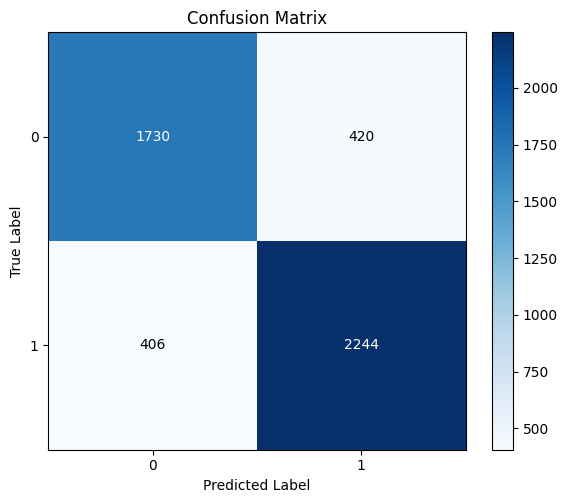


❌ Jumlah prediksi salah: 826
📄 Log kesalahan disimpan ke: wrong_predictions.csv


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import os

# === Evaluasi Model Terbaik === #
best_model.eval()
all_preds, all_labels, all_scores, all_file_names = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_scores.extend(probs.tolist())
        all_file_names.extend(file_names)

# === Hitung Metrik === #
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Evaluasi Model pada Data Uji")
print("=" * 40)
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print(f"✅ Recall     : {recall:.4f}")
print(f"✅ Precision  : {precision:.4f}")
print("\n🧩 Confusion Matrix:\n", cm)
print("=" * 40)

# === Simpan ke File Teks === #
with open("test_evaluation_report.txt", "w") as f:
    f.write("📊 Evaluasi Model pada Data Uji\n")
    f.write("=" * 40 + "\n")
    f.write(f"Accuracy   : {acc:.4f}\n")
    f.write(f"F1 Score   : {f1:.4f}\n")
    f.write(f"Recall     : {recall:.4f}\n")
    f.write(f"Precision  : {precision:.4f}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm) + "\n")
    f.write("=" * 40 + "\n")

# === Gambar Confusion Matrix === #
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()

# === Simpan Prediksi yang Salah === #
wrong_preds = []
for fname, pred, label, score in zip(all_file_names, all_preds, all_labels, all_scores):
    if pred != label:
        wrong_preds.append({
            'file_name': fname,
            'true_label': label,
            'predicted_label': pred,
            'score_0': score[0],
            'score_1': score[1],
        })

wrong_log_path = "wrong_predictions.csv"
with open(wrong_log_path, mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['file_name', 'true_label', 'predicted_label', 'score_0', 'score_1'])
    writer.writeheader()
    for row in wrong_preds:
        writer.writerow(row)

print(f"\n❌ Jumlah prediksi salah: {len(wrong_preds)}")
print(f"📄 Log kesalahan disimpan ke: {wrong_log_path}")


90 10 cm layout

In [ ]:
import random
import numpy as np
import torch
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fungsi untuk set semua seed agar eksperimen bisa diulang
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)  # Panggil fungsi seed di awal

for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === RANDOM SEARCH === #
keys, values = zip(*param_grid.items())
all_possible = list(product(*values))
num_samples = min(20, len(all_possible))
sampled_combinations = random.sample(all_possible, num_samples)
all_combinations = [dict(zip(keys, v)) for v in sampled_combinations]

best_acc = 0
best_params = None
best_model = None
results = []

for i, params in enumerate(all_combinations):
    print(f"\n🔎 Eksperimen {i+1}/{num_samples}: {params}")

    # Train GCN dengan early stopping dan validasi
    val_acc, val_loss, model = train_gcn_once(
        params,
        train_loader,
        val_loader,
        in_channels,
        num_classes=2,
        use_early_stopping=True  # pastikan kamu support ini di fungsimu
    )

    print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    results.append({
        'experiment': i + 1,
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

# === TEST EVALUATION === #
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Best Accuracy (Val):", best_acc)
print("📌 Best Hyperparameters:", best_params)
print("🧪 Test Accuracy:", test_acc)
# Simpan model terbaik
model_path = "gcn_tataletak.pth"
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model terbaik disimpan ke '{model_path}'")

# Simpan hasil ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("hyperparam_search_results.csv", index=False)
print("💾 Hasil eksperimen disimpan ke 'hyperparam_search_results.csv'")


Output hidden; open in https://colab.research.google.com to view.


🔎 Menjalankan eksperimen tunggal dengan params: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.0, 'weight_decay': 0.0001}
⛔ Early stopping at epoch 79


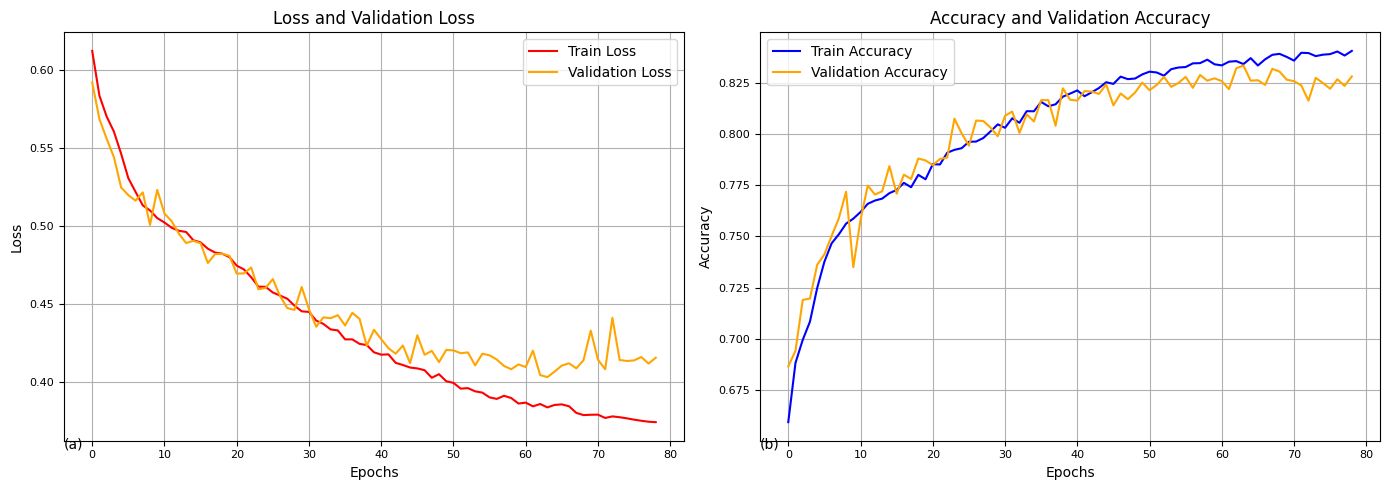

➡️ Val Accuracy: 0.8333 | Val Loss: 0.4034

✅ Validation Accuracy: 0.8333333333333334
🧪 Test Accuracy: 0.8591666666666666
💾 Model disimpan ke 'gcn_cm_layout.pth'
💾 Hasil eksperimen disimpan ke 'single_experiment_result.csv'


In [8]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import copy
import pandas as pd

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed setting
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)

# Ambil input feature size
for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === SINGLE EXPERIMENT === #
params = {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.0, 'weight_decay': 0.0001}

print(f"\n🔎 Menjalankan eksperimen tunggal dengan params: {params}")

# Fungsi pelatihan
val_acc, val_loss, best_model = train_gcn_once(
    params,
    train_loader,
    val_loader,
    in_channels,
    num_classes=2,
    use_early_stopping=True
)

print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

# Evaluasi di test set
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Validation Accuracy:", val_acc)
print("🧪 Test Accuracy:", test_acc)

# Simpan model
model_path = "gcn_cm_layout.pth"
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model disimpan ke '{model_path}'")

# Simpan hasil eksperimen
results = [{
    'params': params,
    'val_acc': val_acc,
    'val_loss': val_loss,
    'test_acc': test_acc
}]
df_results = pd.DataFrame(results)
df_results.to_csv("single_experiment_result.csv", index=False)
print("💾 Hasil eksperimen disimpan ke 'single_experiment_result.csv'")


In [11]:
from sklearn.metrics import classification_report

# === TEST EVALUATION DENGAN CLASSIFICATION REPORT === #
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
print("\n📋 Classification Report di Test Set:")
print(classification_report(true_labels, pred_labels, digits=4))



📋 Classification Report di Test Set:
              precision    recall  f1-score   support

           0     0.8163    0.8898    0.8515      1089
           1     0.9011    0.8337    0.8661      1311

    accuracy                         0.8592      2400
   macro avg     0.8587    0.8618    0.8588      2400
weighted avg     0.8626    0.8592    0.8595      2400




📊 Evaluasi Model pada Data Uji
✅ Accuracy   : 0.8592
✅ F1 Score   : 0.8661
✅ Recall     : 0.8337
✅ Precision  : 0.9011

🧩 Confusion Matrix:
 [[ 969  120]
 [ 218 1093]]


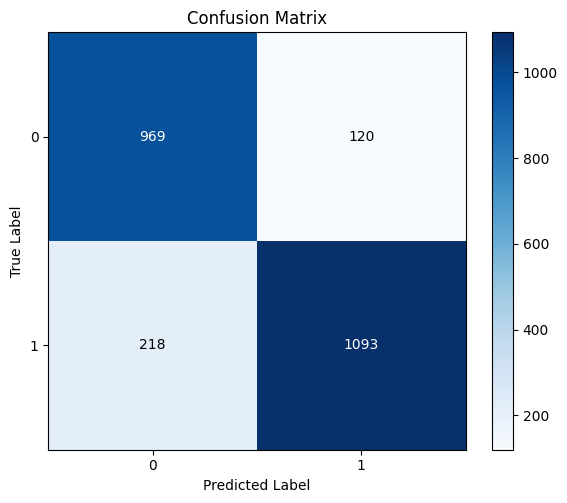


❌ Jumlah prediksi salah: 338
📄 Log kesalahan disimpan ke: wrong_predictions.csv


In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import os

# === Evaluasi Model Terbaik === #
best_model.eval()
all_preds, all_labels, all_scores, all_file_names = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_scores.extend(probs.tolist())
        all_file_names.extend(file_names)

# === Hitung Metrik === #
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Evaluasi Model pada Data Uji")
print("=" * 40)
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print(f"✅ Recall     : {recall:.4f}")
print(f"✅ Precision  : {precision:.4f}")
print("\n🧩 Confusion Matrix:\n", cm)
print("=" * 40)

# === Simpan ke File Teks === #
with open("test_evaluation_report.txt", "w") as f:
    f.write("📊 Evaluasi Model pada Data Uji\n")
    f.write("=" * 40 + "\n")
    f.write(f"Accuracy   : {acc:.4f}\n")
    f.write(f"F1 Score   : {f1:.4f}\n")
    f.write(f"Recall     : {recall:.4f}\n")
    f.write(f"Precision  : {precision:.4f}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm) + "\n")
    f.write("=" * 40 + "\n")

# === Gambar Confusion Matrix === #
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()

# === Simpan Prediksi yang Salah === #
wrong_preds = []
for fname, pred, label, score in zip(all_file_names, all_preds, all_labels, all_scores):
    if pred != label:
        wrong_preds.append({
            'file_name': fname,
            'true_label': label,
            'predicted_label': pred,
            'score_0': score[0],
            'score_1': score[1],
        })

wrong_log_path = "wrong_predictions.csv"
with open(wrong_log_path, mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['file_name', 'true_label', 'predicted_label', 'score_0', 'score_1'])
    writer.writeheader()
    for row in wrong_preds:
        writer.writerow(row)

print(f"\n❌ Jumlah prediksi salah: {len(wrong_preds)}")
print(f"📄 Log kesalahan disimpan ke: {wrong_log_path}")


In [ ]:
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNGraphClassifier(nn.Module):
    def __init__(self, input_dim=2800, hidden_dim=128, num_classes=2):
        super(GCNGraphClassifier, self).__init__()

        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.gcn2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)  # agregasi semua node dalam graf
        out = self.classifier(x)
        return out


In [ ]:
# Pastikan class GCNGraphClassifier sudah didefinisikan sebelum ini
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ambil fitur dari data
sample = train_data[0]
in_channels = sample.num_node_features

# Inisialisasi model
model = GCNGraphClassifier(in_channels=in_channels, hidden_channels=256, num_classes=2).to(device)
print(model)


GCNGraphClassifier(
  (conv1): GCNConv(3, 256)
  (conv2): GCNConv(256, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.num_graphs
            all_preds.extend(pred.cpu().tolist())
            all_labels.extend(batch.y.cpu().tolist())
    accuracy = correct / total
    return accuracy, (all_preds, all_labels)


In [ ]:
import torch

# Path ke file .pt
file_path = "/content/drive/MyDrive/Hasil_Ekstraksi/color/train_graphs_color_1.pt"

# Load data
graph_data = torch.load(file_path,  weights_only=False)

# Cari file_name
target_name = "13089.jpg"
found = False

for i, graph in enumerate(graph_data):
    file_name = getattr(graph, 'file_name', None)
    if file_name == target_name:
        print(f"✅ Ditemukan pada index {i}:")
        print(graph)
        found = True
        break

if not found:
    print(f"❌ file_name '{target_name}' tidak ditemukan dalam dataset.")


✅ Ditemukan pada index 0:
Data(x=[9, 12], edge_index=[2, 12], y=0, file_name='13089.jpg')


WARNA SAJA 90 10

[Epoch 1] Loss: 0.6199 | Val Loss: 0.6062 | Train Acc: 0.6659 | Val Acc: 0.6653
[Epoch 2] Loss: 0.6044 | Val Loss: 0.6060 | Train Acc: 0.6671 | Val Acc: 0.6637
[Epoch 3] Loss: 0.5993 | Val Loss: 0.5971 | Train Acc: 0.6833 | Val Acc: 0.6789
[Epoch 4] Loss: 0.5991 | Val Loss: 0.5989 | Train Acc: 0.6848 | Val Acc: 0.6826
[Epoch 5] Loss: 0.5943 | Val Loss: 0.5932 | Train Acc: 0.6826 | Val Acc: 0.6775
[Epoch 6] Loss: 0.5932 | Val Loss: 0.5987 | Train Acc: 0.6824 | Val Acc: 0.6826
[Epoch 7] Loss: 0.5915 | Val Loss: 0.5898 | Train Acc: 0.6850 | Val Acc: 0.6854
[Epoch 8] Loss: 0.5890 | Val Loss: 0.5922 | Train Acc: 0.6884 | Val Acc: 0.6822
[Epoch 9] Loss: 0.5878 | Val Loss: 0.5903 | Train Acc: 0.6898 | Val Acc: 0.6782
[Epoch 10] Loss: 0.5874 | Val Loss: 0.5881 | Train Acc: 0.6909 | Val Acc: 0.6875
[Epoch 11] Loss: 0.5884 | Val Loss: 0.5956 | Train Acc: 0.6736 | Val Acc: 0.6650
[Epoch 12] Loss: 0.5878 | Val Loss: 0.6009 | Train Acc: 0.6931 | Val Acc: 0.6854
[Epoch 13] Loss: 0.5865 | Val Loss: 0

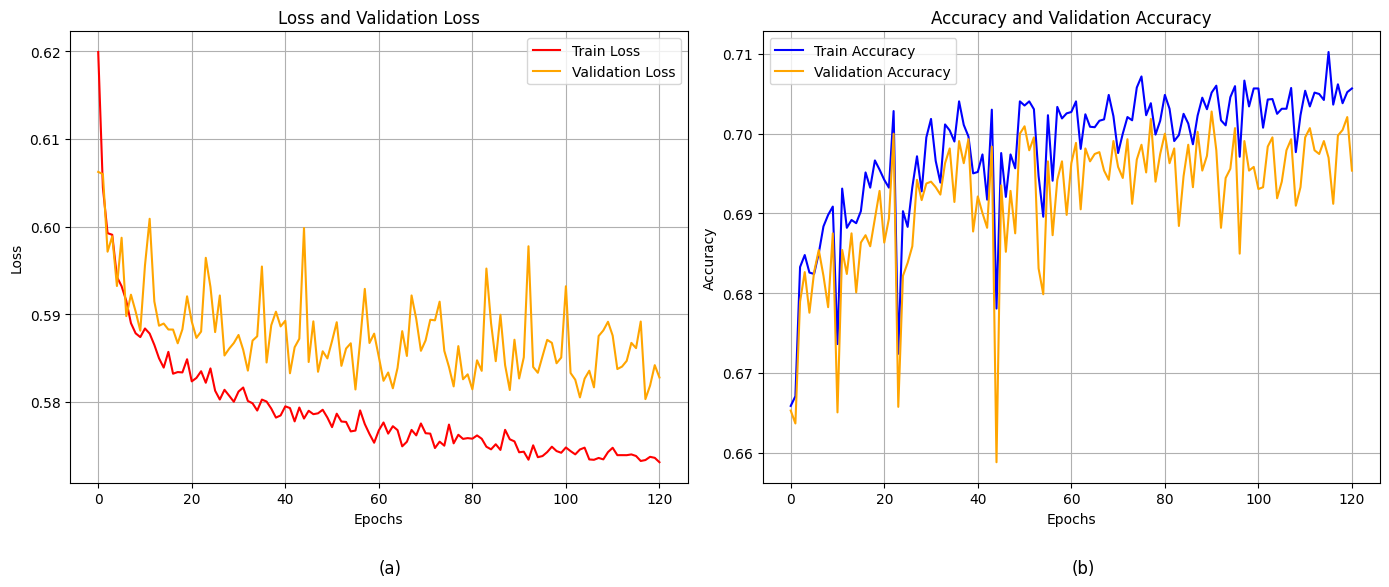

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# ⚙️ Konfigurasi awal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.097, 0.919], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi gabungan: Loss (a) dan Accuracy (b)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gambar (a) - Loss
ax1.plot(train_losses, label="Train Loss", color="red")
ax1.plot(val_losses, label="Validation Loss", color="orange")
ax1.set_title("Loss and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.text(0.5, -0.2, "(a)", transform=ax1.transAxes, fontsize=12)

# Gambar (b) - Accuracy
ax2.plot(train_accuracies, label="Train Accuracy", color="blue")
ax2.plot(val_accuracies, label="Validation Accuracy", color="orange")
ax2.set_title("Accuracy and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)
ax2.text(0.5, -0.2, "(b)", transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("combined_loss_accuracy_gcn.png")  # Simpan hasil jika perlu
plt.show()


WARNA SAJA 80 20

[Epoch 1] Loss: 0.6203 | Val Loss: 0.6049 | Train Acc: 0.6643 | Val Acc: 0.6576
[Epoch 2] Loss: 0.6073 | Val Loss: 0.5937 | Train Acc: 0.6777 | Val Acc: 0.6740
[Epoch 3] Loss: 0.6022 | Val Loss: 0.5994 | Train Acc: 0.6788 | Val Acc: 0.6779
[Epoch 4] Loss: 0.5996 | Val Loss: 0.5886 | Train Acc: 0.6833 | Val Acc: 0.6839
[Epoch 5] Loss: 0.5967 | Val Loss: 0.5896 | Train Acc: 0.6831 | Val Acc: 0.6839
[Epoch 6] Loss: 0.5940 | Val Loss: 0.5869 | Train Acc: 0.6896 | Val Acc: 0.6885
[Epoch 7] Loss: 0.5931 | Val Loss: 0.5918 | Train Acc: 0.6843 | Val Acc: 0.6794
[Epoch 8] Loss: 0.5928 | Val Loss: 0.5858 | Train Acc: 0.6870 | Val Acc: 0.6799
[Epoch 9] Loss: 0.5901 | Val Loss: 0.5831 | Train Acc: 0.6910 | Val Acc: 0.6839
[Epoch 10] Loss: 0.5887 | Val Loss: 0.5913 | Train Acc: 0.6932 | Val Acc: 0.6870
[Epoch 11] Loss: 0.5899 | Val Loss: 0.5871 | Train Acc: 0.6925 | Val Acc: 0.6867
[Epoch 12] Loss: 0.5870 | Val Loss: 0.5865 | Train Acc: 0.6910 | Val Acc: 0.6797
[Epoch 13] Loss: 0.5882 | Val Loss: 0

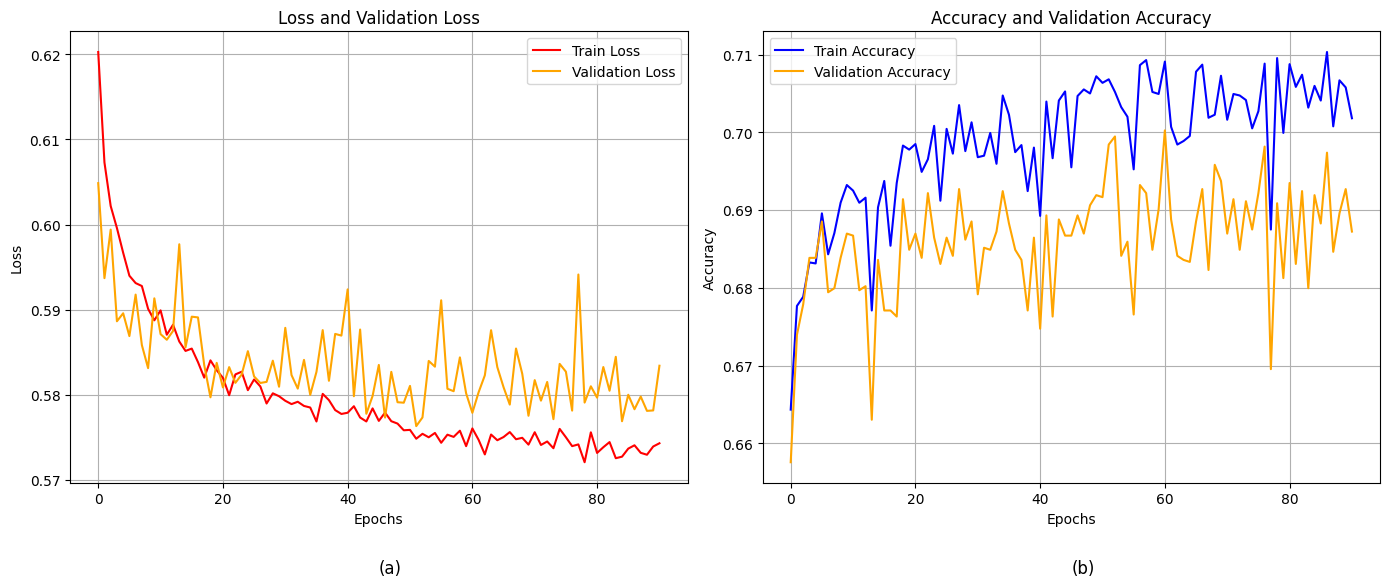

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# ⚙️ Konfigurasi awal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.097, 0.919], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi gabungan: Loss (a) dan Accuracy (b)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gambar (a) - Loss
ax1.plot(train_losses, label="Train Loss", color="red")
ax1.plot(val_losses, label="Validation Loss", color="orange")
ax1.set_title("Loss and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.text(0.5, -0.2, "(a)", transform=ax1.transAxes, fontsize=12)

# Gambar (b) - Accuracy
ax2.plot(train_accuracies, label="Train Accuracy", color="blue")
ax2.plot(val_accuracies, label="Validation Accuracy", color="orange")
ax2.set_title("Accuracy and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)
ax2.text(0.5, -0.2, "(b)", transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("combined_loss_accuracy_gcn.png")  # Simpan hasil jika perlu
plt.show()


tata letak dan rasio aspek 90 10

[Epoch 1] Loss: 0.6911 | Val Loss: 0.6809 | Train Acc: 0.5330 | Val Acc: 0.5301
[Epoch 2] Loss: 0.6592 | Val Loss: 0.6308 | Train Acc: 0.7844 | Val Acc: 0.7850
[Epoch 3] Loss: 0.6245 | Val Loss: 0.6125 | Train Acc: 0.7902 | Val Acc: 0.7903
[Epoch 4] Loss: 0.6073 | Val Loss: 0.6075 | Train Acc: 0.7781 | Val Acc: 0.7812
[Epoch 5] Loss: 0.6000 | Val Loss: 0.6008 | Train Acc: 0.7904 | Val Acc: 0.7910
[Epoch 6] Loss: 0.5933 | Val Loss: 0.5942 | Train Acc: 0.7933 | Val Acc: 0.7954
[Epoch 7] Loss: 0.5876 | Val Loss: 0.5795 | Train Acc: 0.7846 | Val Acc: 0.7831
[Epoch 8] Loss: 0.5788 | Val Loss: 0.5837 | Train Acc: 0.7752 | Val Acc: 0.7787
[Epoch 9] Loss: 0.5766 | Val Loss: 0.5686 | Train Acc: 0.7835 | Val Acc: 0.7819
[Epoch 10] Loss: 0.5689 | Val Loss: 0.5673 | Train Acc: 0.7859 | Val Acc: 0.7861
[Epoch 11] Loss: 0.5649 | Val Loss: 0.5595 | Train Acc: 0.7826 | Val Acc: 0.7831
[Epoch 12] Loss: 0.5606 | Val Loss: 0.5475 | Train Acc: 0.7891 | Val Acc: 0.7898
[Epoch 13] Loss: 0.5575 | Val Loss: 0

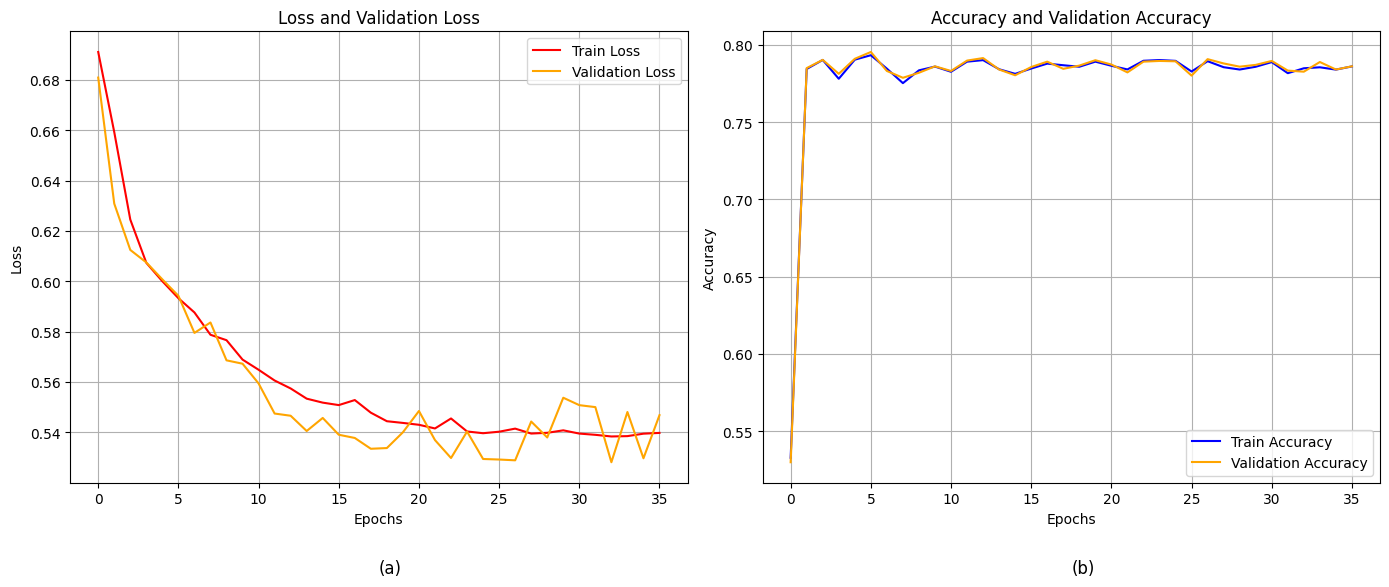

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# ⚙️ Konfigurasi awal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.097, 0.919], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi gabungan: Loss (a) dan Accuracy (b)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gambar (a) - Loss
ax1.plot(train_losses, label="Train Loss", color="red")
ax1.plot(val_losses, label="Validation Loss", color="orange")
ax1.set_title("Loss and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.text(0.5, -0.2, "(a)", transform=ax1.transAxes, fontsize=12)

# Gambar (b) - Accuracy
ax2.plot(train_accuracies, label="Train Accuracy", color="blue")
ax2.plot(val_accuracies, label="Validation Accuracy", color="orange")
ax2.set_title("Accuracy and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)
ax2.text(0.5, -0.2, "(b)", transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("combined_loss_accuracy_gcn.png")  # Simpan hasil jika perlu
plt.show()


tata letak dan rasio aspek 80 20

[Epoch 1] Loss: 0.6929 | Val Loss: 0.6888 | Train Acc: 0.5377 | Val Acc: 0.5411
[Epoch 2] Loss: 0.6719 | Val Loss: 0.6398 | Train Acc: 0.7106 | Val Acc: 0.7055
[Epoch 3] Loss: 0.6341 | Val Loss: 0.6202 | Train Acc: 0.7960 | Val Acc: 0.7948
[Epoch 4] Loss: 0.6165 | Val Loss: 0.6076 | Train Acc: 0.7893 | Val Acc: 0.7893
[Epoch 5] Loss: 0.6072 | Val Loss: 0.5977 | Train Acc: 0.7878 | Val Acc: 0.7898
[Epoch 6] Loss: 0.6039 | Val Loss: 0.5932 | Train Acc: 0.7942 | Val Acc: 0.7937
[Epoch 7] Loss: 0.5969 | Val Loss: 0.5901 | Train Acc: 0.7835 | Val Acc: 0.7870
[Epoch 8] Loss: 0.5923 | Val Loss: 0.5919 | Train Acc: 0.7961 | Val Acc: 0.7951
[Epoch 9] Loss: 0.5880 | Val Loss: 0.5814 | Train Acc: 0.7859 | Val Acc: 0.7875
[Epoch 10] Loss: 0.5846 | Val Loss: 0.5819 | Train Acc: 0.7921 | Val Acc: 0.7909
[Epoch 11] Loss: 0.5791 | Val Loss: 0.5764 | Train Acc: 0.7949 | Val Acc: 0.7940
[Epoch 12] Loss: 0.5720 | Val Loss: 0.5760 | Train Acc: 0.7845 | Val Acc: 0.7880
[Epoch 13] Loss: 0.5702 | Val Loss: 0

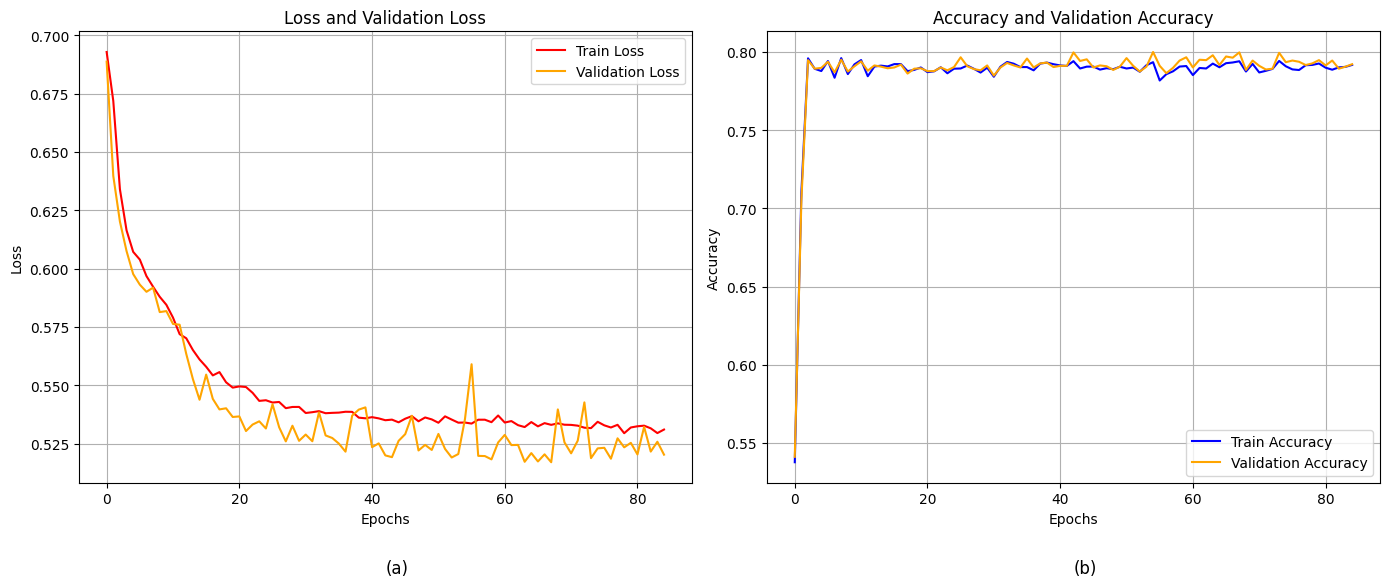

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# ⚙️ Konfigurasi awal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.097, 0.919], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi gabungan: Loss (a) dan Accuracy (b)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gambar (a) - Loss
ax1.plot(train_losses, label="Train Loss", color="red")
ax1.plot(val_losses, label="Validation Loss", color="orange")
ax1.set_title("Loss and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.text(0.5, -0.2, "(a)", transform=ax1.transAxes, fontsize=12)

# Gambar (b) - Accuracy
ax2.plot(train_accuracies, label="Train Accuracy", color="blue")
ax2.plot(val_accuracies, label="Validation Accuracy", color="orange")
ax2.set_title("Accuracy and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)
ax2.text(0.5, -0.2, "(b)", transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("combined_loss_accuracy_gcn.png")  # Simpan hasil jika perlu
plt.show()


 color moments + layout

[Epoch 1] Loss: 0.6183 | Val Loss: 0.6016 | Train Acc: 0.6649 | Val Acc: 0.6574
[Epoch 2] Loss: 0.5988 | Val Loss: 0.5869 | Train Acc: 0.6859 | Val Acc: 0.6826
[Epoch 3] Loss: 0.5925 | Val Loss: 0.5870 | Train Acc: 0.6861 | Val Acc: 0.6900
[Epoch 4] Loss: 0.5833 | Val Loss: 0.5857 | Train Acc: 0.7001 | Val Acc: 0.7002
[Epoch 5] Loss: 0.5763 | Val Loss: 0.5655 | Train Acc: 0.7153 | Val Acc: 0.7130
[Epoch 6] Loss: 0.5628 | Val Loss: 0.5502 | Train Acc: 0.7239 | Val Acc: 0.7169
[Epoch 7] Loss: 0.5502 | Val Loss: 0.5404 | Train Acc: 0.7432 | Val Acc: 0.7382
[Epoch 8] Loss: 0.5393 | Val Loss: 0.5332 | Train Acc: 0.7389 | Val Acc: 0.7336
[Epoch 9] Loss: 0.5297 | Val Loss: 0.5094 | Train Acc: 0.7648 | Val Acc: 0.7697
[Epoch 10] Loss: 0.5249 | Val Loss: 0.5210 | Train Acc: 0.7523 | Val Acc: 0.7509
[Epoch 11] Loss: 0.5190 | Val Loss: 0.5054 | Train Acc: 0.7738 | Val Acc: 0.7731
[Epoch 12] Loss: 0.5148 | Val Loss: 0.4935 | Train Acc: 0.7692 | Val Acc: 0.7729
[Epoch 13] Loss: 0.5084 | Val Loss: 0

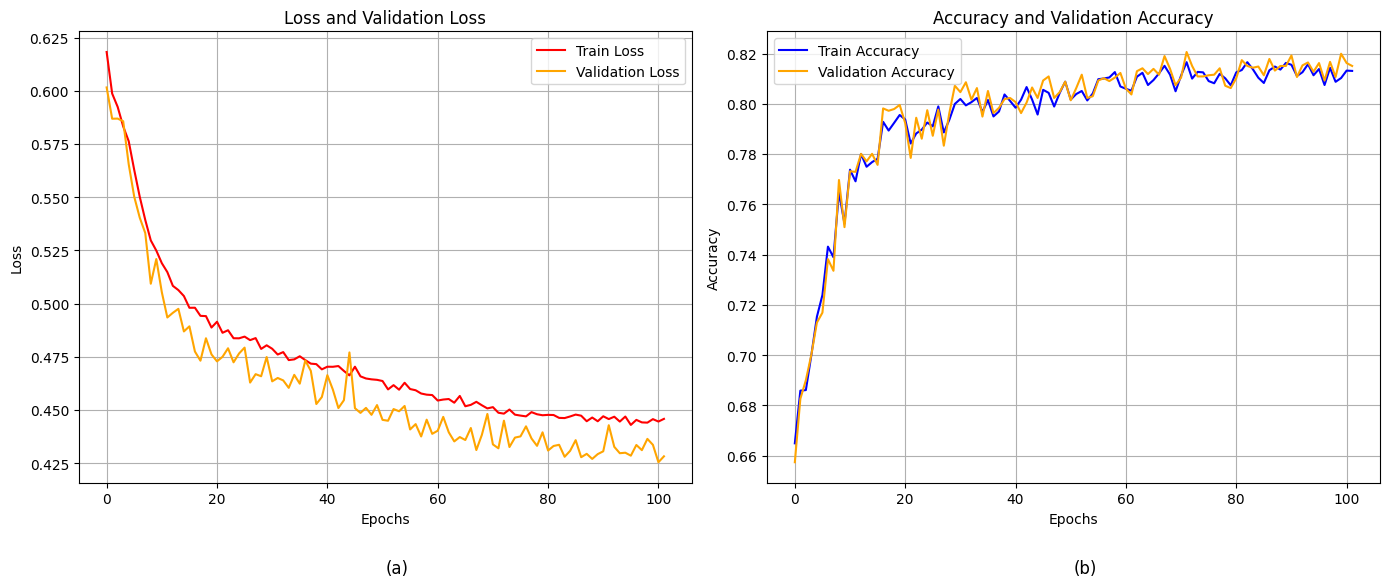

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# ⚙️ Konfigurasi awal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.097, 0.919], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi gabungan: Loss (a) dan Accuracy (b)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gambar (a) - Loss
ax1.plot(train_losses, label="Train Loss", color="red")
ax1.plot(val_losses, label="Validation Loss", color="orange")
ax1.set_title("Loss and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.text(0.5, -0.2, "(a)", transform=ax1.transAxes, fontsize=12)

# Gambar (b) - Accuracy
ax2.plot(train_accuracies, label="Train Accuracy", color="blue")
ax2.plot(val_accuracies, label="Validation Accuracy", color="orange")
ax2.set_title("Accuracy and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)
ax2.text(0.5, -0.2, "(b)", transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("combined_loss_accuracy_gcn.png")  # Simpan hasil jika perlu
plt.show()


Color mOments normalisasi

[Epoch 1] Loss: 0.5735 | Val Loss: 0.5876 | Train Acc: 0.6984 | Val Acc: 0.6884
[Epoch 2] Loss: 0.5703 | Val Loss: 0.5792 | Train Acc: 0.7063 | Val Acc: 0.7025
[Epoch 3] Loss: 0.5712 | Val Loss: 0.5786 | Train Acc: 0.7054 | Val Acc: 0.6981
[Epoch 4] Loss: 0.5696 | Val Loss: 0.5772 | Train Acc: 0.7101 | Val Acc: 0.7000
[Epoch 5] Loss: 0.5670 | Val Loss: 0.5776 | Train Acc: 0.7101 | Val Acc: 0.7028
[Epoch 6] Loss: 0.5657 | Val Loss: 0.5778 | Train Acc: 0.7163 | Val Acc: 0.7049
[Epoch 7] Loss: 0.5649 | Val Loss: 0.5810 | Train Acc: 0.7049 | Val Acc: 0.6910
[Epoch 8] Loss: 0.5642 | Val Loss: 0.5815 | Train Acc: 0.7178 | Val Acc: 0.7039
[Epoch 9] Loss: 0.5637 | Val Loss: 0.5765 | Train Acc: 0.7180 | Val Acc: 0.7014
[Epoch 10] Loss: 0.5626 | Val Loss: 0.5768 | Train Acc: 0.7177 | Val Acc: 0.7037
[Epoch 11] Loss: 0.5612 | Val Loss: 0.5800 | Train Acc: 0.7175 | Val Acc: 0.7069
[Epoch 12] Loss: 0.5599 | Val Loss: 0.5798 | Train Acc: 0.7191 | Val Acc: 0.7042
[Epoch 13] Loss: 0.5603 | Val Loss: 0

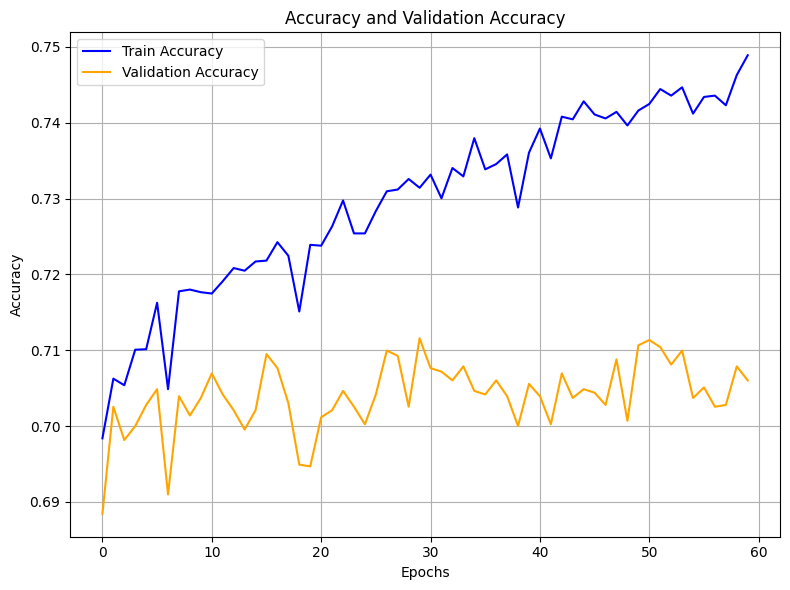

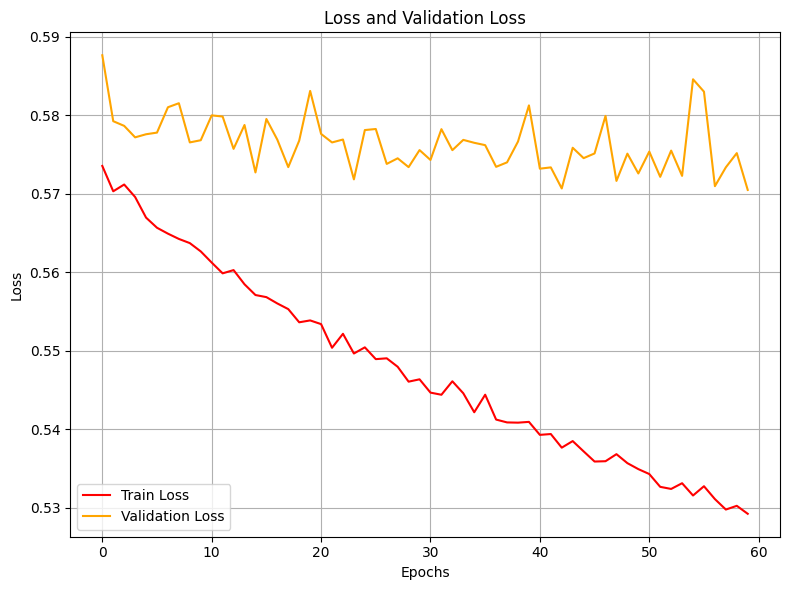

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch.utils.data import DataLoader

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.100, 0.917], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi akurasi
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label="Train Accuracy", color="blue")
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.title("Accuracy and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_val_accuracy.png")
plt.show()

# 🎨 Visualisasi loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss", color="red")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.title("Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_val_loss.png")
plt.show()



Contoh Prediksi (Top 5):
File: 22912.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.4434 | Score 1: 0.5566
File: 22913.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.4424 | Score 1: 0.5576
File: 22914.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.8367 | Score 1: 0.1633
File: 22915.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.6602 | Score 1: 0.3398
File: 22916.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.9085 | Score 1: 0.0915

🔎 Evaluasi Data Testing
Accuracy  : 0.6679
F1 Score  : 0.6267
Recall    : 0.5103
Precision : 0.8119
Confusion Matrix:
 [[934 155]
 [642 669]]


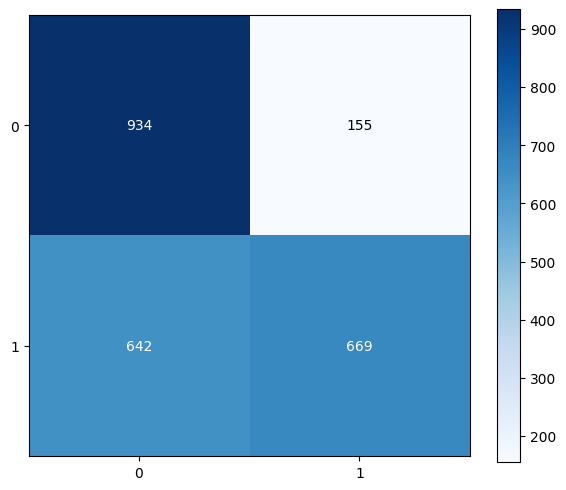

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


color saja 90 10


Contoh Prediksi (Top 5):
File: 22912.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.2679 | Score 1: 0.7321
File: 22913.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.1805 | Score 1: 0.8195
File: 22914.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.7679 | Score 1: 0.2321
File: 22915.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.5690 | Score 1: 0.4310
File: 22916.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.7327 | Score 1: 0.2673

🔎 Evaluasi Data Testing
Accuracy  : 0.6967
F1 Score  : 0.7024
Recall    : 0.6552
Precision : 0.7568
Confusion Matrix:
 [[813 276]
 [452 859]]


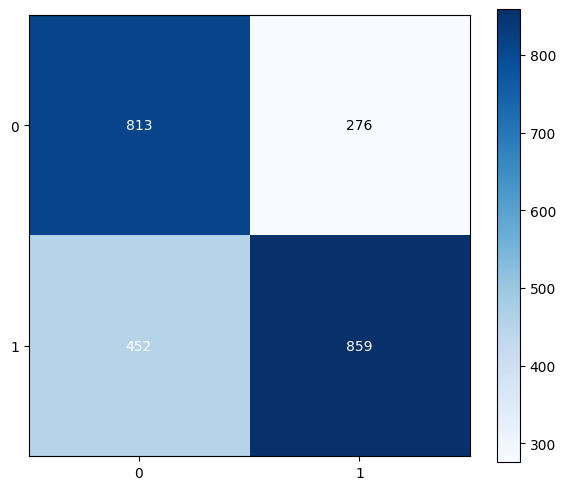

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


color saja 80 20


Contoh Prediksi (Top 5):
File: 13091.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.6189 | Score 1: 0.3811
File: 13096.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.3430 | Score 1: 0.6570
File: 13100.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.6466 | Score 1: 0.3534
File: 13102.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.6249 | Score 1: 0.3751
File: 13103.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.5202 | Score 1: 0.4798

🔎 Evaluasi Data Testing
Accuracy  : 0.6956
F1 Score  : 0.6971
Recall    : 0.6343
Precision : 0.7736
Confusion Matrix:
 [[1658  492]
 [ 969 1681]]


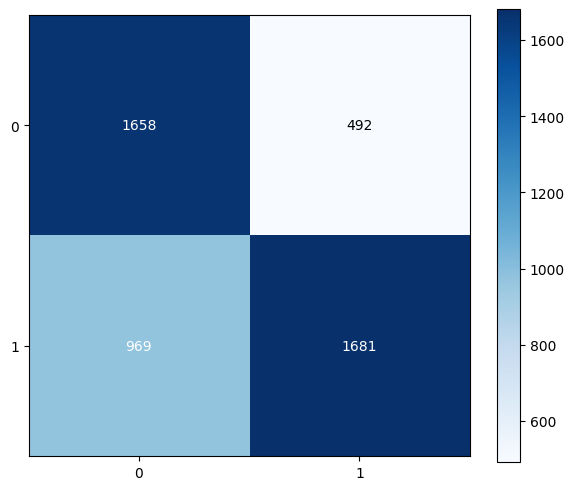

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


tata letak saja


Contoh Prediksi (Top 5):
File: 22912.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.3160 | Score 1: 0.6840
File: 22913.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.1876 | Score 1: 0.8124
File: 22914.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.3160 | Score 1: 0.6840
File: 22915.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.7967 | Score 1: 0.2033
File: 22916.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.7967 | Score 1: 0.2033

🔎 Evaluasi Data Testing
Accuracy  : 0.8104
F1 Score  : 0.8197
Recall    : 0.7887
Precision : 0.8531
Confusion Matrix:
 [[ 911  178]
 [ 277 1034]]


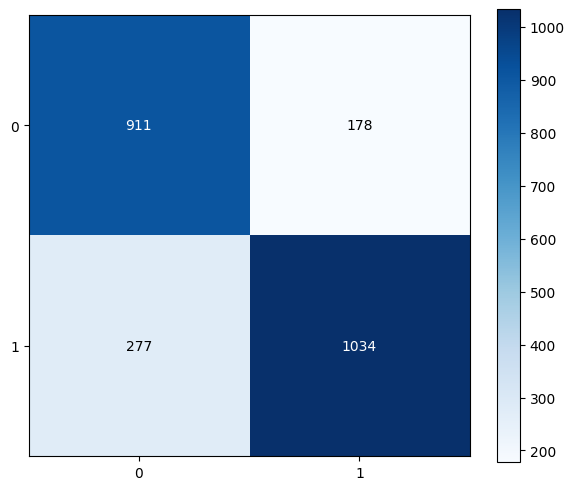

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


color monets normalisasi


Contoh Prediksi (Top 5):
File: 22912.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.3361 | Score 1: 0.6639
File: 22913.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.1882 | Score 1: 0.8118
File: 22914.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.8027 | Score 1: 0.1973
File: 22915.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.6582 | Score 1: 0.3418
File: 22916.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.7663 | Score 1: 0.2337

🔎 Evaluasi Data Testing
Accuracy  : 0.7113
F1 Score  : 0.7253
Recall    : 0.6979
Precision : 0.7550
Confusion Matrix:
 [[792 297]
 [396 915]]


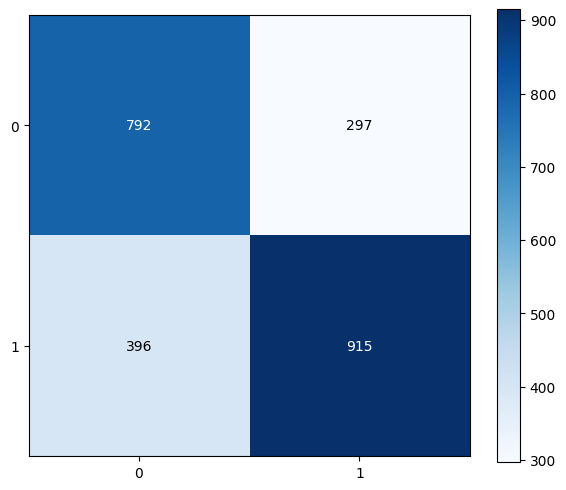

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


color + layout


Contoh Prediksi (Top 5):
File: 22912.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.0669 | Score 1: 0.9331
File: 22913.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.0962 | Score 1: 0.9038
File: 22914.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.4183 | Score 1: 0.5817
File: 22915.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.9126 | Score 1: 0.0874
File: 22916.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.8540 | Score 1: 0.1460

🔎 Evaluasi Data Testing
Accuracy  : 0.8317
F1 Score  : 0.8370
Recall    : 0.7910
Precision : 0.8886
Confusion Matrix:
 [[ 959  130]
 [ 274 1037]]


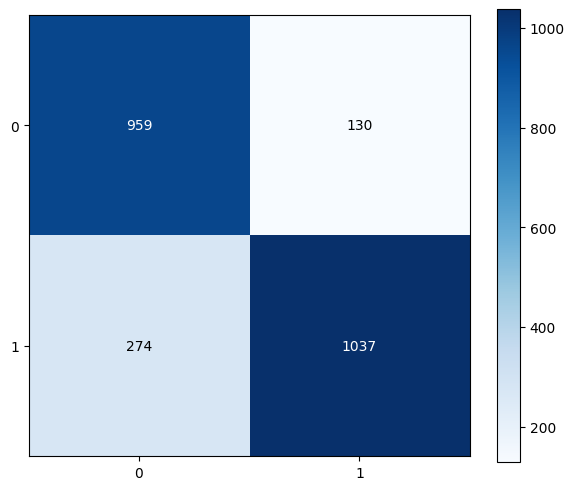

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


In [ ]:
import pandas as pd

# 🚨 Simpan data yang salah prediksi (FP dan FN)
false_positives = []
false_negatives = []

for i in range(len(all_preds)):
    true_label = all_labels[i]
    pred_label = all_preds[i]
    if pred_label != true_label:
        entry = {
            "file_name": all_file_names[i],
            "label": true_label,
            "prediction": pred_label,
            "score_0": all_scores[i][0],
            "score_1": all_scores[i][1]
        }
        if true_label == 0 and pred_label == 1:
            false_positives.append(entry)
        elif true_label == 1 and pred_label == 0:
            false_negatives.append(entry)

# 💾 Simpan ke file CSV
pd.DataFrame(false_positives).to_csv("false_positives.csv", index=False)
pd.DataFrame(false_negatives).to_csv("false_negatives.csv", index=False)

print(f"\n📁 Jumlah False Positives (FP): {len(false_positives)}")
print(f"📁 Jumlah False Negatives (FN): {len(false_negatives)}")
print("✅ Data salah prediksi telah disimpan sebagai 'false_positives.csv' dan 'false_negatives.csv'")



📁 Jumlah False Positives (FP): 178
📁 Jumlah False Negatives (FN): 277
✅ Data salah prediksi telah disimpan sebagai 'false_positives.csv' dan 'false_negatives.csv'


In [ ]:
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

for epoch in range(1, 101):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []
    all_file_names = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Kumpulkan prediksi dan label
        out_cpu = out.detach().cpu()
        preds = out_cpu.argmax(dim=1)
        labels = batch.y.cpu()

        # Ambil nama file jika ada
        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)

    # Hitung metrik evaluasi
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # Logging ringkasan ke file
    log_file = os.path.join(log_dir, f"epoch_{epoch}.txt")
    with open(log_file, "w") as f:
        f.write(f"[Epoch {epoch}] Train Loss: {total_loss / len(train_loader):.4f}\n")
        f.write(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}\n")
        f.write(f"Confusion Matrix:\n{cm}\n\n")
        for name, pred, label in zip(all_file_names, all_preds, all_labels):
            f.write(f"{name}: Pred = {pred}, Label = {label}\n")

    # Print ke console
    print(f"[Epoch {epoch}] Loss: {total_loss / len(train_loader):.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    # Simpan prediksi dan label dari epoch terakhir (atau terbaik)
if epoch == 100:
    import pickle
    with open("final_preds.pkl", "wb") as f:
        pickle.dump({
            "preds": all_preds,
            "labels": all_labels,
            "file_names": all_file_names
        }, f)
    print("✅ Disimpan: final_preds.pkl")



[Epoch 1] Loss: 0.0970 | Acc: 0.9614 | F1: 0.9613
Confusion Matrix:
[[10867    43]
 [  884 12206]]
[Epoch 2] Loss: 0.0849 | Acc: 0.9601 | F1: 0.9600
Confusion Matrix:
[[10779   131]
 [  826 12264]]
[Epoch 3] Loss: 0.1142 | Acc: 0.9566 | F1: 0.9563
Confusion Matrix:
[[10401   509]
 [  532 12558]]
[Epoch 4] Loss: 0.0849 | Acc: 0.9614 | F1: 0.9613
Confusion Matrix:
[[10853    57]
 [  869 12221]]
[Epoch 5] Loss: 0.0825 | Acc: 0.9609 | F1: 0.9608
Confusion Matrix:
[[10822    88]
 [  850 12240]]
[Epoch 6] Loss: 0.0921 | Acc: 0.9620 | F1: 0.9619
Confusion Matrix:
[[10851    59]
 [  852 12238]]
[Epoch 7] Loss: 0.0985 | Acc: 0.9582 | F1: 0.9580
Confusion Matrix:
[[10761   149]
 [  855 12235]]
[Epoch 8] Loss: 0.0981 | Acc: 0.9562 | F1: 0.9560
Confusion Matrix:
[[10679   231]
 [  820 12270]]
[Epoch 9] Loss: 0.0854 | Acc: 0.9577 | F1: 0.9576
Confusion Matrix:
[[10727   183]
 [  831 12259]]
[Epoch 10] Loss: 0.1017 | Acc: 0.9534 | F1: 0.9532
Confusion Matrix:
[[10609   301]
 [  818 12272]]
[Epoch 11

In [ ]:
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 5.9 MB/s eta 0:00:00a 0:00:01


🔎 Evaluasi Keseluruhan:
Accuracy : 0.9532
Precision: 0.9621
Recall   : 0.9517
F1 Score : 0.9569
Confusion Matrix:
 [[10419   491]
 [  632 12458]]


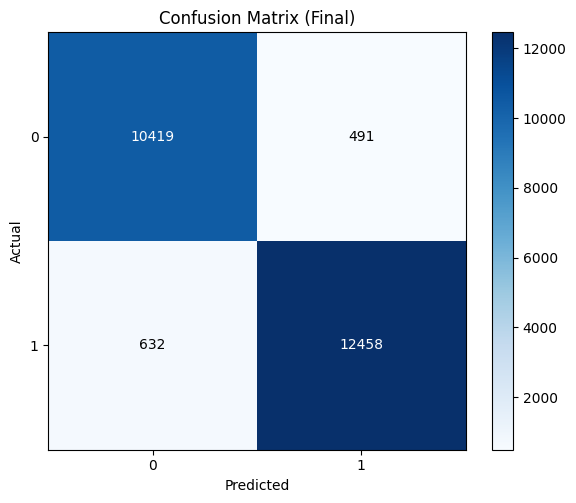

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load hasil prediksi akhir
with open("final_preds.pkl", "rb") as f:
    data = pickle.load(f)

y_pred = data["preds"]
y_true = data["labels"]

# Hitung metrik evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='binary')
rec = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
cm = confusion_matrix(y_true, y_pred)

# Cetak hasilnya
print("🔎 Evaluasi Keseluruhan:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Final)")
plt.colorbar()

tick_marks = np.arange(len(set(y_true)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Tampilkan angka
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig("confusion_matrix_final.png")
plt.show()


In [ ]:
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset 80% train, 20% test
total = len(dataset)
train_size = int(0.8 * total)
test_size = total - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Inisialisasi model
sample = dataset[0]
model = GCNGraphClassifier(sample.num_node_features, 64, 2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
eval_epochs = []
accs = []
precisions = []
recalls = []
f1s = []

# Training
for epoch in range(1, 101):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Hitung test loss
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)

    # Simpan loss setiap 10 epoch
    if epoch % 10 == 0:
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

    # Evaluasi setiap 5 epoch
    if epoch % 5 == 0:
        model.eval()
        y_true = []
        y_pred = []
        misclassified_files = []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                preds = out.argmax(dim=1).cpu()
                labels = batch.y.cpu()

                y_true.extend(labels.numpy())
                y_pred.extend(preds.numpy())

                # ⬅️ Tracking file yang salah prediksi
                if hasattr(batch, 'file_name'):  # cek apakah file_name tersedia
                    for i in range(len(preds)):
                        if preds[i] != labels[i]:
                            misclassified_files.append(batch.file_name[i])


        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        accs.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        eval_epochs.append(epoch)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
        print(f"           Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        if misclassified_files:
            print(f"  Salah prediksi ({len(misclassified_files)} graf):")
            for name in misclassified_files[:5]:  # tampilkan 5 contoh saja
                print(f"   - {name}")


# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(10, 101, 10), train_losses, label='Train Loss', marker='o')
plt.plot(range(10, 101, 10), test_losses, label='Test Loss', marker='s')
plt.title('Loss per 10 Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot metrik evaluasi
plt.figure(figsize=(10, 6))
plt.plot(eval_epochs, accs, label='Accuracy', marker='o')
plt.plot(eval_epochs, precisions, label='Precision', marker='s')
plt.plot(eval_epochs, recalls, label='Recall', marker='^')
plt.plot(eval_epochs, f1s, label='F1-score', marker='d')
plt.title('Evaluasi Model Setiap 5 Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
out = model(batch.x, batch.edge_index, batch.batch)  # output mentah
probs = torch.softmax(out, dim=1)                    # ubah jadi probabilitas

# Ambil probabilitas kelas estetik (label = 1)
prob_estetik = probs[:, 1]  # shape [batch_size]

for i, prob in enumerate(prob_estetik):
    print(f"Graf ke-{i+1} → Estetik dengan kemungkinan {prob.item():.2%}")
